In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from tqdm.notebook import tqdm
sys.path.insert(0, '..')


from util.evaluation import load_results, map_signal_to_sigmoid_range, balance_df
from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, get_results_based_on_treshold
from util.plot_utils import collect_results_based_on_confidence_level_based_on_percentile as collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results500.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results500.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results500.csv')
    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) :
        checkpoint_dir_paths.append(model_folder)

In [4]:
space = 'linear'
n_values = 12
MIN_PERC = 1

assert space in ['log', 'linear']

In [ ]:
df_full, name_map, confidence_level = load_results(checkpoint_dir_paths[:16], space, n_values, MIN_PERC, chkpt_folder)

#df = otain_results(checkpoint_dir_paths[:3], space, n_values, MIN_PERC)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_full = df_full.groupby('model').mean().reset_index()

# Curve

In [8]:
n_best = 5
min_auc_on_all_dataset = 0.53
way = 3

In [9]:
plt.rcParams['figure.figsize'] = [10, 7]

In [10]:
df_auc = df_full.filter(['model', 'paris_auc_interactors',  'ricseq_auc_interactors', 'splash_auc_interactors', 'splashtest_auc_interactors'])

In [11]:
if way == 1:
    #way1
    df_select = df_auc[(df_auc.drop('model', axis = 1) > min_auc_on_all_dataset * 100).all(axis = 1)]
    best_models = set(df_select.sort_values('mean', ascending = False).head(n_best)['model']).union(set(['INTARNA']))
elif way == 2:
    #way2
    best_paris = set(df_select.sort_values('paris_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_ricseq = set(df_select.sort_values('ricseq_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_splash = set(df_select.sort_values('splash_auc_interactors', ascending = False).head( int(n_best) )['model'])
    best_models = ( best_paris.intersection(best_ricseq).intersection(best_splash) ).union(set(['INTARNA']))
elif way == 3:
    #take the best in ricseq
    best_models = set(df_auc.sort_values('ricseq_auc_interactors', ascending = False).head(n_best)['model']).union(set(['INTARNA']))

In [12]:
task_name = 'patches' #interactors, patches
metric = 'precision_recall_curve' #precision_recall_curve, f1
model_list = ['splashtest', 'ricseq', 'paris']

diz_curve = {}

for set_name in model_list:
    diz_dataset = {}
    for model in best_models:
        datasetlist = []
        for conf in confidence_level:
            modelrow = df_full[df_full['model'] == model]
            
            value = modelrow[f'{set_name}_{task_name}_{metric}_conf{conf}'].iloc[0]
            
            datasetlist.append(value)  
        diz_dataset[model] = datasetlist
    diz_curve[set_name] = diz_dataset

In [13]:
df_curve = pd.DataFrame.from_dict(diz_curve, 'index')#.reset_index().rename({'index':'dataset'}, axis = 1)

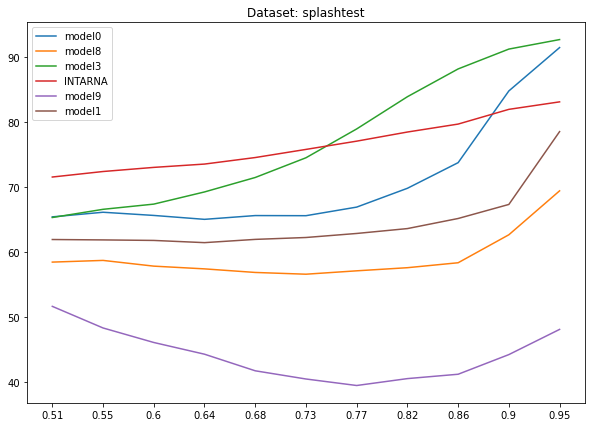

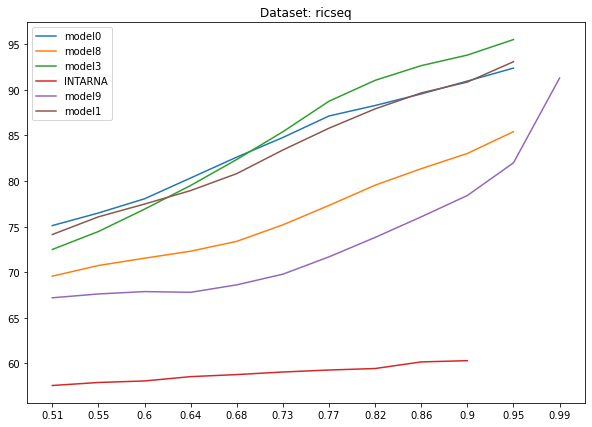

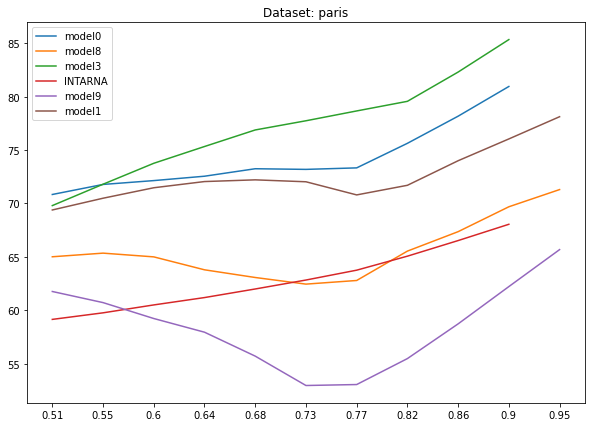

In [14]:
for dataset in model_list:
    row = df_curve.loc[dataset]
    for model in best_models:
        plt.plot(confidence_level, row[model], label = model)
      
    plt.title(f'Dataset: {dataset}')
    plt.legend()
    plt.show()

In [15]:
df_auc[df_auc.model.isin(best_models)]

,model,paris_auc_interactors,ricseq_auc_interactors,splash_auc_interactors,splashtest_auc_interactors
0,INTARNA,51.894444,54.734444,71.078889,68.81
1,model0,59.170000,59.270000,60.970000,56.37
2,model1,58.830000,60.490000,61.490000,57.28
9,model3,59.850000,59.720000,61.710000,58.08
14,model8,59.710000,60.450000,62.160000,57.61
15,model9,58.140000,60.140000,62.830000,56.21


In [17]:
for i in list(best_models):
    if i != 'INTARNA':
        print(i, name_map[i])

model3 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_parisANDsplashRICSEQval0094
model0 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_parisANDsplashRICSEQval0081
model1 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_parisANDsplashRICSEQval0083
model2 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_parisANDsplashRICSEQval0136


In [36]:
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splash103
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_easypretrain10_paristfinetuningSPLASHval29_ricseqSPLASHval60_splashRICSEQval110
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28_splashBEST
# /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151

In [37]:
columns_to_print = ['model', 
                    'paris_auc_ES', 'paris_auc_EPENHN',
                    'ricseq_auc_ES', 'ricseq_auc_EPENHN',
                    'splash_auc_ES', 'splash_auc_EPENHN']
df_full[df_full['model'].isin(models_selected)|(df_full['model']=='INTARNA')].filter(columns_to_print, axis = 1).round(2)

NameError: name 'models_selected' is not defined

In [ ]:
models_selected = ['model7', 'model9', 'model10', 'model12', 'model15', 'model21', 'model22', 'model23', 'model24', 'model25', 'model26']

In [ ]:
columns_to_print = ['model', 
                    'paris_auc_ES', 'paris_auc_EPENHN',
                    'ricseq_auc_ES', 'ricseq_acc_ES_notrain', 'ricseq_auc_EPENHN',
                    'splash_auc_ES', 'splash_auc_EPENHN']
df_full[df_full['model'].isin(models_selected)|(df_full['model']=='INTARNA')].filter(columns_to_print, axis = 1).round(2)

### Correlation between ricsecTest VS ricseq, splashTest VS splash

Sembra esserci una correlazione abbastanza forte, quindi posso utilizzare i dati di test per fare tutte le altre analisi.

In [ ]:
only_test = False
df_full_F, name_map_F, confidence_level = otain_results(checkpoint_dir_paths, space, n_values, MIN_PERC, only_test)

In [ ]:
ok_ricseq = [ os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch1_easypretrain7_paristrain22', 
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12'
]]



ok_splash = [os.path.join(chkpt_folder, i) for i in [
    'all_modelarch2_easypretrain3_paristfinetuningSPLASHval8', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29', 
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval30',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHvalBEST',
             'all_modelarch1_easypretrain7_paristrain22',
             'all_modelarch1_easypretrain7_paristrain12_trainhq',
             'all_modelarch2_easypretrain3_paristfinetuning13',
             'all_modelarch2_easypretrain3_paristfinetuning14',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq20',
             'all_modelarch2_easypretrain3_paristfinetuning14_ricseq23',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18',
             'all_modelarch1_paristfinetuningSPLASHval25_ricseqSPLASHval28',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval12',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval18_ricseqSPLASHval20',
             'all_modelarch2_easypretrain3_paristfinetuningSPLASHval29_ricseqSPLASHvalBEST'
]]

In [ ]:
map_splash = {}
for i in ok_splash:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_splash = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_splash_F = j
    map_splash[name_map_splash] = name_map_splash_F

map_splash = pd.DataFrame.from_dict(map_splash, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)
    
map_ricseq = {}
for i in ok_ricseq:
    for j in name_map.keys():
        if name_map[j] == i:
            name_map_ricseq = j
    for j in name_map_F.keys():
        if name_map[j] == i:
            name_map_ricseq_F = j
    map_ricseq[name_map_ricseq] = name_map_ricseq_F
    
map_ricseq = pd.DataFrame.from_dict(map_ricseq, 'index').reset_index().rename({'index':'name_map', 0:'name_map_F'}, axis = 1)


In [121]:
#assert we dont have to change names of the dataframes, otherwise we have to modify the names, I didnt implement this case
if ((map_ricseq.name_map == map_ricseq.name_map_F).all()) & ((map_splash.name_map == map_splash.name_map_F).all()):
    pass
else:
    raise NotImplementedError

In [122]:
df_ricseq = df_full[df_full['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]
df_ricseq_F = df_full_F[df_full_F['model'].isin(set(map_ricseq['name_map']))][['model', 'ricseq_auc_ES']]

df_splash = df_full[df_full['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]
df_splash_F = df_full_F[df_full_F['model'].isin(set(map_splash['name_map']))][['model', 'splash_auc_ES']]

In [123]:
df_ricseq = df_ricseq.merge(df_ricseq_F, on = 'model').drop('model', axis = 1).rename(
    {'ricseq_auc_ES_x':'ricseq_auc_ES_Test', 
    'ricseq_auc_ES_y':'ricseq_auc_ES_Full'}, axis = 1)

df_splash = df_splash.merge(df_splash_F, on = 'model').drop('model', axis = 1).rename(
    {'splash_auc_ES_x':'splash_auc_ES_Test', 
    'splash_auc_ES_y':'splash_auc_ES_Full'}, axis = 1)

Correlation Matrix:
                    ricseq_auc_ES_Test  ricseq_auc_ES_Full
ricseq_auc_ES_Test            1.000000            0.986051
ricseq_auc_ES_Full            0.986051            1.000000


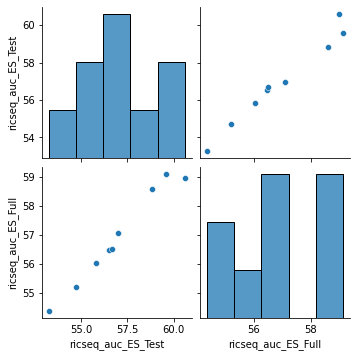

In [124]:
plot_correlation(df_ricseq)

Correlation Matrix:
                    splash_auc_ES_Test  splash_auc_ES_Full
splash_auc_ES_Test            1.000000            0.762477
splash_auc_ES_Full            0.762477            1.000000


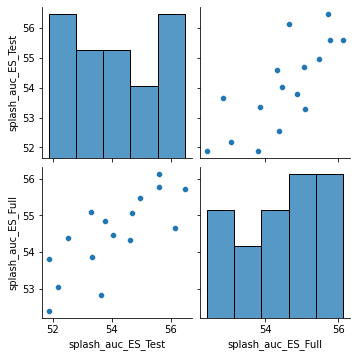

In [125]:
plot_correlation(df_splash)